In [ ]:
Кейс
В компании SkyCrossroads запущена рекламная акция:
Клиент может получить дополнительные баллы лояльности за покупку, совершенную в течение ограниченного периода.
Классическая акция подразумевает получение дополнительных 1000 баллов лояльности за покупку от 100 рублей.
Было решено запустить АБ Тест, в котором в тестовой группе предлагается в два раза больше баллов лояльности за покупку от 100 рублей.
Эксперимент был проведен в нескольких торговых точках.
Также у нас есть информация о том, как долго клиент зарегистрирован у нас в программе лояльности.

In [ ]:
#ЧАСТЬ 1

In [112]:
#Анализ данных

In [89]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from  scipy.stats import ttest_ind
import scipy.stats as sps
import matplotlib.patches as mpatches

In [90]:
ABtest = pd.read_csv('C:/Users/Xenia/Desktop/Учёба/Python/Групповой проект/Dataset_AB_TEST.csv',sep=';')
ABtest

,id_client,id_group,sum_pay,id_point,months_reg
0,1420218,test,3288.0,1199.0,8
1,1390221,control,1267.0,1182.0,11
2,1363404,control,4259.0,1178.0,2
3,1370042,test,7211.0,1179.0,3
4,1360376,control,760.0,1178.0,14
...,...,...,...,...,...
10971,1359021,control,799.0,1178.0,3
10972,1363347,control,4825.0,1178.0,6
10973,1373031,test,673.0,1179.0,1
10974,1370292,test,1120.0,1179.0,1


In [91]:
metrics = ABtest.groupby('id_group', as_index= False).agg({'id_client': 'count', 'sum_pay': 'sum'})
metrics['avg_pay'] = round(metrics['sum_pay']/metrics['id_client'],2)
metrics

,id_group,id_client,sum_pay,avg_pay
0,control,5202,17874939.0,3436.17
1,test,5700,20842331.0,3656.55


In [92]:
ABtest.isna().mean() #Проверим выборку на наличие пустых ячеек

id_client     0.000000
id_group      0.006742
sum_pay       0.011571
id_point      0.007380
months_reg    0.000000
dtype: float64

In [93]:
ABtest=ABtest.dropna() #Чистим данные от пустых ячеек
ABtest.head()

,id_client,id_group,sum_pay,id_point,months_reg
0,1420218,test,3288.0,1199.0,8
1,1390221,control,1267.0,1182.0,11
2,1363404,control,4259.0,1178.0,2
3,1370042,test,7211.0,1179.0,3
4,1360376,control,760.0,1178.0,14


<Figure size 2160x720 with 0 Axes>

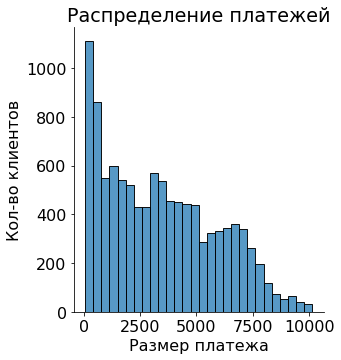

In [116]:
plt.rcParams['font.size'] = '16'
plt.figure(figsize=(30,10))
sns.displot(ABtest['sum_pay']) #Проверяем данные на выбросы(могут повлиять на результат)
plt.title('Распределение платежей')
plt.xlabel('Размер платежа')
plt.ylabel('Кол-во клиентов')
plt.savefig('Выбросы.png')

In [95]:
ABtest=ABtest[ABtest['sum_pay']<15000] #Удаляем выбросы

In [96]:
#Строим функцию statistical_analysis для проверки данных и вычисления осн.показателей

In [97]:
def statistical_analysis(r,q=[0.1,0.25,0.3,0.4,0.5,0.6,0.75,0.9]):
    list_r= list()
    list_r=r.tolist()
    if type(list_r)!= list and tuple:
        return 'Нужен список или кортеж!'
    else:
        if len(list_r)<=4:
            return 'Требуется более длинный ряд'
        else:
            if type(list_r)==list and tuple:
                list_r_series=pd.Series(list_r)
                mean=round(list_r_series.mean(),2)
                var=round(list_r_series.var(),2)
                std=round(list_r_series.std(),2)
                quantile=list_r_series.quantile(q)
                quantile=quantile.tolist()
                print(f'Среднее - {mean}')
                print(f'Дисперсия - {var}')
                print(f'Стандартное отклонение - {std}')
                print()
                quantile_name=['Квантиль 0.1','Квартиль 1','Квантиль 0.3','Квантиль 0.4','Медиана','Квантиль 0.6','Квартиль 3','Квантиль 0.9']
                for i in range(len(quantile)):
                    print(quantile_name[i],' - ',round(quantile[i],2))

In [98]:
statistical_analysis(ABtest['sum_pay'])#проверяем выборку

Среднее - 3431.38
Дисперсия - 6023895.9
Стандартное отклонение - 2454.36

Квантиль 0.1  -  409.0
Квартиль 1  -  1237.0
Квантиль 0.3  -  1576.0
Квантиль 0.4  -  2307.0
Медиана  -  3155.0
Квантиль 0.6  -  3899.0
Квартиль 3  -  5274.0
Квантиль 0.9  -  7011.0


In [99]:
#ЧАСТЬ 2

In [100]:
#A/B тест

In [101]:
#Разбиваем данные выборки для тестовой и контрольной группы 
data1 = ABtest.loc[ABtest['id_group'] == 'test']
data2 = ABtest.loc[ABtest['id_group'] == 'control']

In [102]:
#строим функцию test_calc, которая будет проводить t-тест на равенство средних двух выборок. 

In [103]:
def ttest_calc(r1,r2,alpha = 0.05): 
    s,p_value = sps.ttest_ind(r1,r2)
    
    if p_value < alpha:
        print ('Распределения не равны')
        print (f'Значение стат.критерия - {s}')
        print (f'Значение p_value - {p_value}')
    else: 
        print ('Распределения равны')
        print (f'Значение стат.критерия - {s}')
        print (f'Значение p_value - {p_value}')

In [104]:
ttest_calc(data1['sum_pay'],data2['sum_pay'])

Распределения не равны
Значение стат.критерия - 3.7141912292177888
Значение p_value - 0.0002048855494553075


In [105]:
#Делаем вывод, что статистически выборки для тестовой и контрольной группы не равны(средние показатели разные)
#p_value меньше уровня значимости, следовательно отклоняем нулевую гипотезу

In [106]:
#Строим функцию mann_whitney_func, которая будет проводить тест Манна-Уитни для двух выборок

In [107]:
def mann_whitney_func(r1,r2,alpha = 0.05): 
    s,p_value = sps.mannwhitneyu(r1,r2)
    
    if p_value < alpha:
        print ('Распределения не равны')
        print (f'Значение стат.критерия - {s}')
        print (f'Значение p_value - {p_value}')
    else: 
        print ('Распределения равны')
        print (f'Значение стат.критерия - {s}')
        print (f'Значение p_value - {p_value}')

In [108]:
mann_whitney_func(data1['sum_pay'],data2['sum_pay'])

Распределения равны
Значение стат.критерия - 14750609.5
Значение p_value - 0.05842125879702285


In [109]:
#Создайте функцию для визуализации show_hist

In [129]:
def show_hist(r1,r2): 
    plt.rcParams['font.size'] = '18'
    plt.figure(figsize=(20,10))
    sns.histplot(r1, color='cornflowerblue', bins=50, label='test')
    sns.histplot(r2, color='goldenrod', bins=50, label='control')
    plt.title('Распределение платежей',fontsize=20)
    plt.xlabel('Размер платежа',fontsize=18)
    plt.ylabel('Кол-во клиентов',fontsize=18)
    plt.grid()
    plt.legend()
    plt.savefig('Распределение общее.png')
    plt.show()

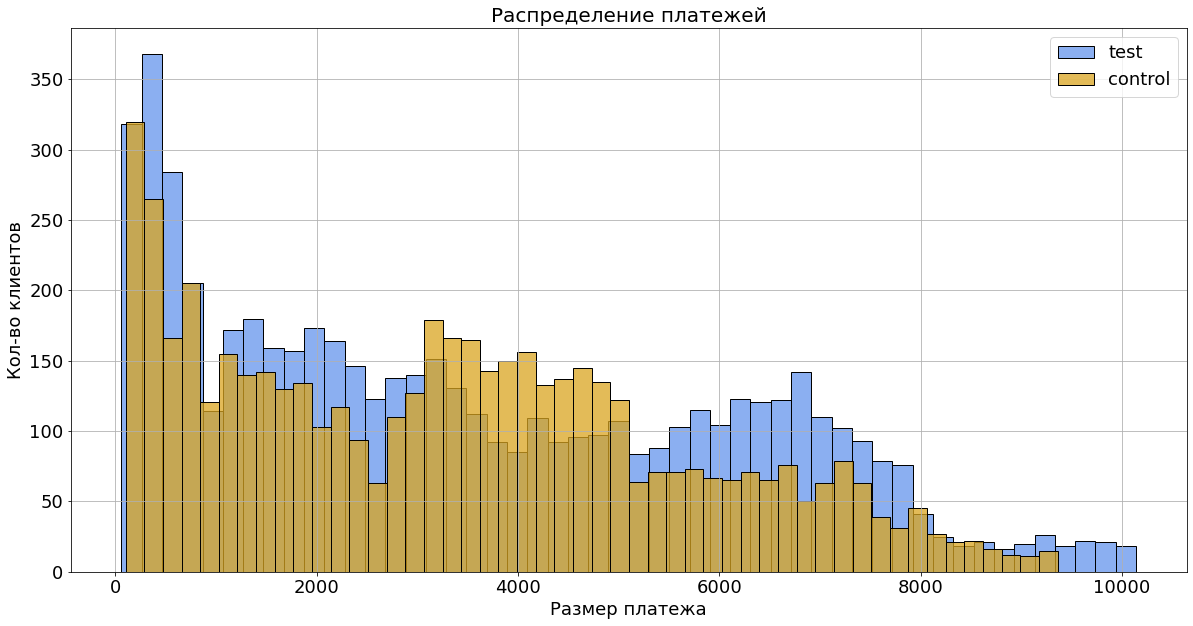

In [136]:
show_hist(data1['sum_pay'],data2['sum_pay'])

In [119]:
#В тестовой группе средний чек на одного клиента увеличивается

In [120]:
metrics = ABtest.groupby('id_group', as_index= False).agg({'id_client': 'count', 'sum_pay': 'sum'})
metrics['avg_pay'] = round(metrics['sum_pay']/metrics['id_client'],2)
metrics

,id_group,id_client,sum_pay,avg_pay
0,control,5140,17165212.0,3339.54
1,test,5621,19759846.0,3515.36


In [121]:
#ЧАСТЬ 3

In [122]:
#Анализ по точкам

In [123]:
#Убедимся, что в торговых точках достаточное количество наблюдений

In [124]:
ABtest.loc[(ABtest.id_group == 'test'), 'id_group'] = 0
ABtest.loc[(ABtest.id_group == 'control'), 'id_group'] = 1
ABtest['flag_test'] = 1 - ABtest['id_group']
ABtest['flag_control'] = 1 - ABtest['flag_test']

ABtest

,id_client,id_group,sum_pay,id_point,months_reg,flag_test,flag_control
0,1420218,0,3288.0,1199.0,8,1,0
1,1390221,1,1267.0,1182.0,11,0,1
2,1363404,1,4259.0,1178.0,2,0,1
3,1370042,0,7211.0,1179.0,3,1,0
4,1360376,1,760.0,1178.0,14,0,1
...,...,...,...,...,...,...,...
10971,1359021,1,799.0,1178.0,3,0,1
10972,1363347,1,4825.0,1178.0,6,0,1
10973,1373031,0,673.0,1179.0,1,1,0
10974,1370292,0,1120.0,1179.0,1,1,0


In [125]:
df_group=ABtest.groupby(['id_point','id_group'])['id_client'].count().reset_index()
df_group

,id_point,id_group,id_client
0,1178.0,0,2406
1,1178.0,1,2403
2,1179.0,0,1745
3,1179.0,1,1697
4,1182.0,0,950
5,1182.0,1,1012
6,1186.0,0,40
7,1186.0,1,23
8,1188.0,0,4
9,1188.0,1,5


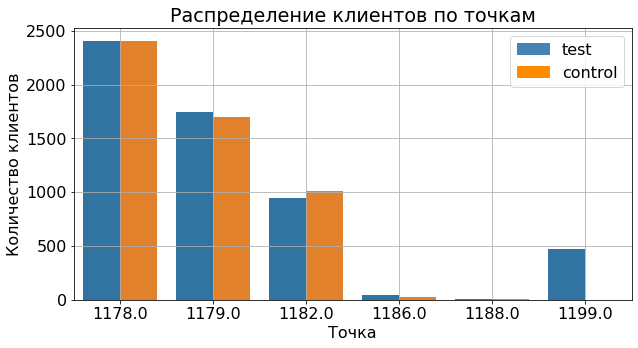

In [128]:
plt.rcParams['font.size'] = '16'
plt.figure(figsize=(10,5))
sns.barplot(x='id_point',y='id_client',hue='id_group',data=df_group)
plt.title('Распределение клиентов по точкам')
plt.xlabel('Точка')
plt.ylabel('Количество клиентов')
plt.grid()
blue_patch = mpatches.Patch(color='steelblue', label='test')
orange_patch = mpatches.Patch(color='darkorange', label='control')
plt.legend(handles=[blue_patch,orange_patch],loc="upper right")
plt.savefig('Распределение клиентов по точкам.png')

In [39]:
for i in ABtest['id_point'].unique():
    print(i)
    s, p = ttest_ind(ABtest[(ABtest['id_point']==i)&(ABtest['id_group']==0)]['sum_pay'],ABtest[(ABtest['id_point']==i)&(ABtest['id_group']==1)]['sum_pay'])
    print(p)
    print()

1199.0
nan

1182.0
1.0387447468996453e-12

1178.0
0.1251217226713009

1179.0
0.2617037465196552

1186.0
0.181936501831722

1188.0
0.8956790614998074



In [714]:
###По точке  1199.0 не равномерное распределение
###По точкам 1186.0 и 1188.0 недостаточно данных
###Релевантны данные только по точкам 1178.0,1179.0 и 1182.0

Торговая точка 1178.0


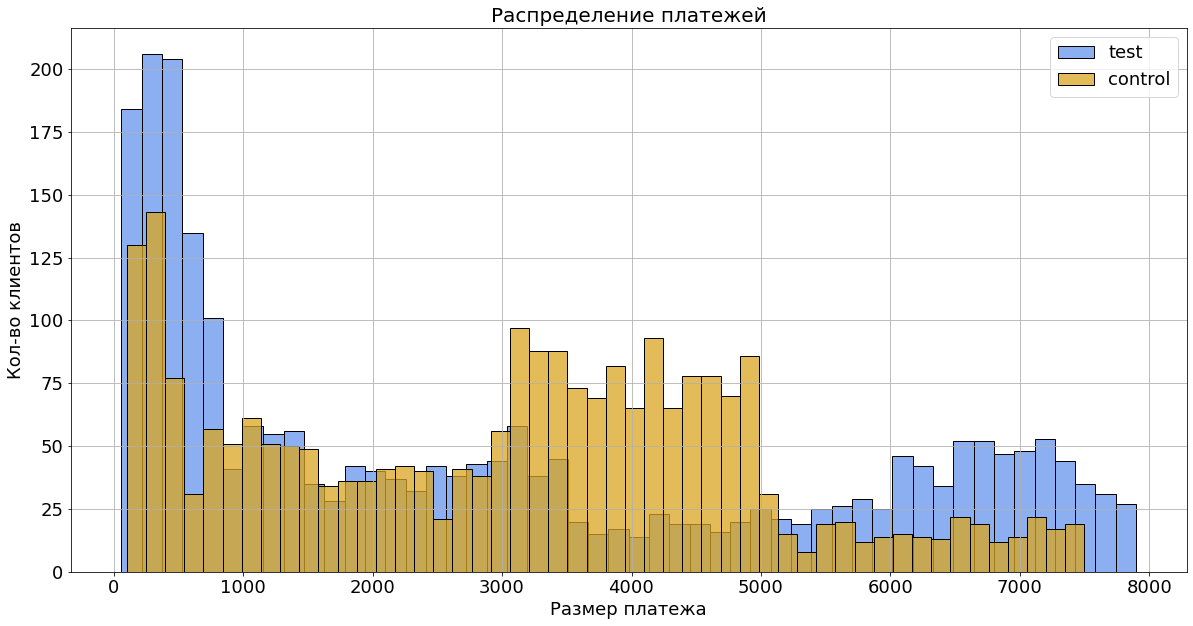

Распределения равны
Значение стат.критерия - -1.5338932633911708
Значение p_value - 0.1251217226713009
Распределения не равны
Значение стат.критерия - 2659280.5
Значение p_value - 1.5133330174771163e-06
Торговая точка 1179.0


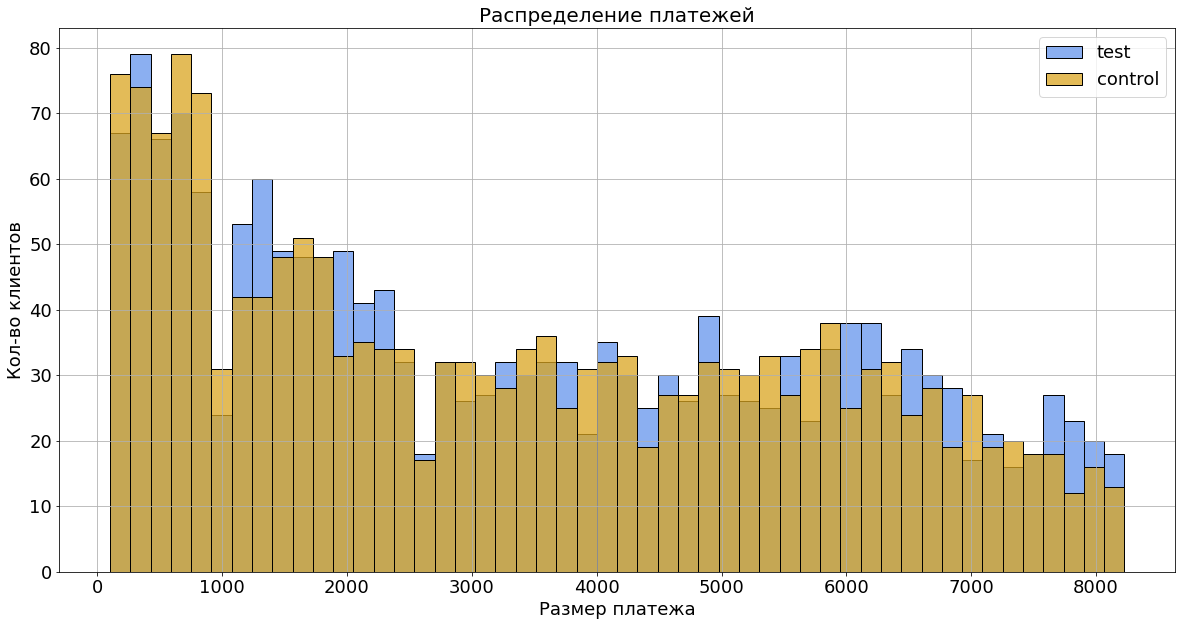

Распределения равны
Значение стат.критерия - 1.1225576641441302
Значение p_value - 0.2617037465196552
Распределения равны
Значение стат.критерия - 1513598.5
Значение p_value - 0.2580763851815786
Торговая точка 1182.0


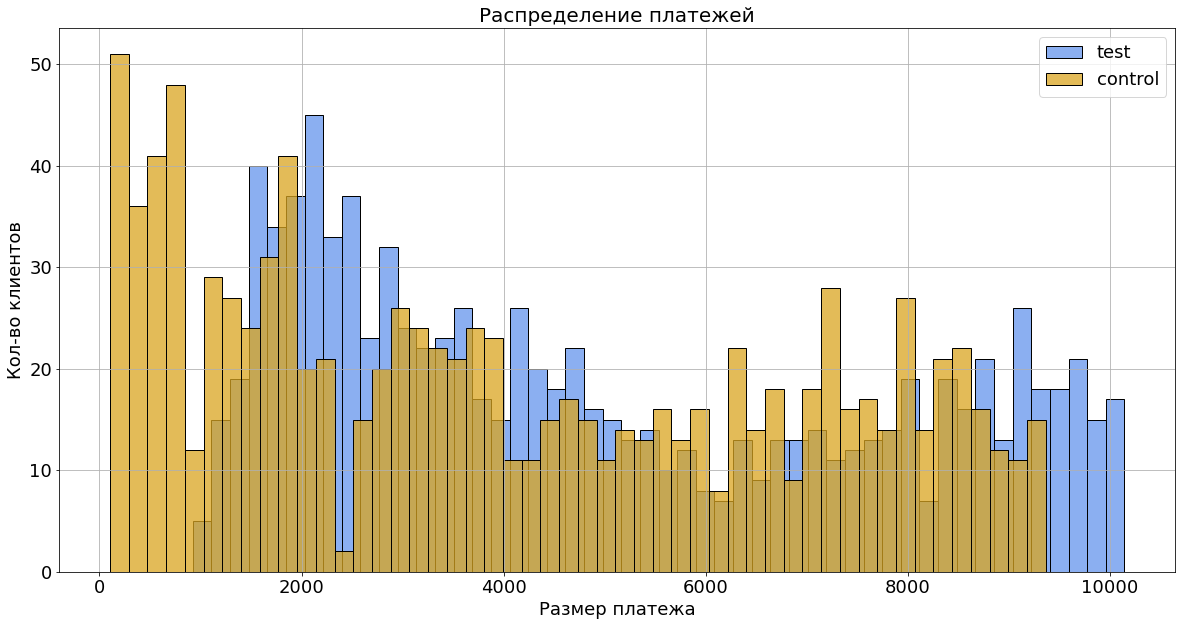

Распределения не равны
Значение стат.критерия - 7.172588995409098
Значение p_value - 1.0387447468996453e-12
Распределения не равны
Значение стат.критерия - 578581.5
Значение p_value - 5.946812205351181e-15


In [131]:
#Проведём анализ только по выбранным точкам
for i in (1178.0,1179.0,1182.0):
    print(f'Торговая точка {i}')
    show_hist(data1.loc[data1['id_point']==i]['sum_pay'],data2.loc[data2['id_point']==i]['sum_pay'])
    ttest_calc(data1.loc[data1['id_point']==i]['sum_pay'],data2.loc[data2['id_point']==i]['sum_pay'])
    mann_whitney_func(data1.loc[data1['id_point']==i]['sum_pay'],data2.loc[data2['id_point']==i]['sum_pay'])

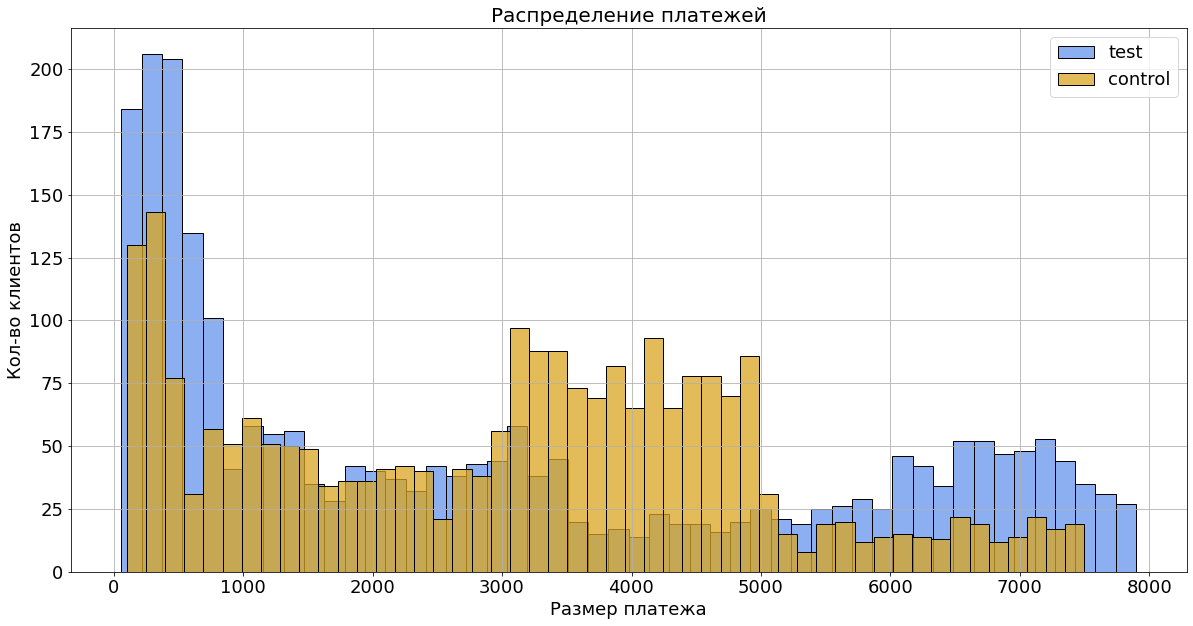

In [135]:
show_hist(data1.loc[data1['id_point']==1178.0]['sum_pay'],data2.loc[data2['id_point']==1178.0]['sum_pay'])

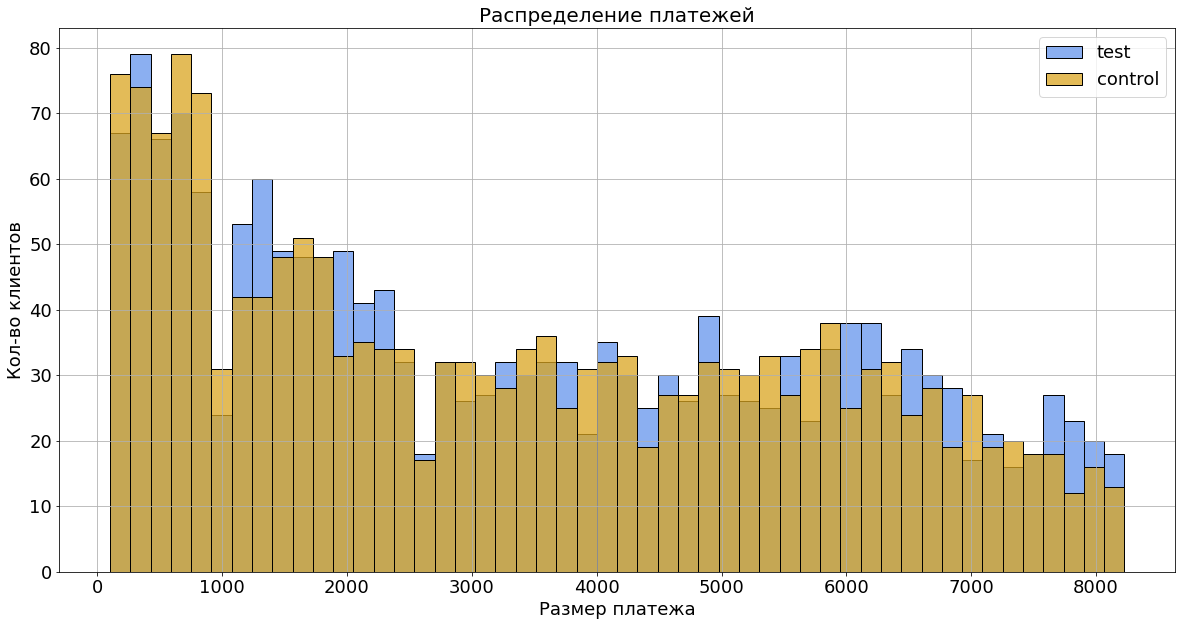

In [137]:
show_hist(data1.loc[data1['id_point']==1179.0]['sum_pay'],data2.loc[data2['id_point']==1179.0]['sum_pay'])

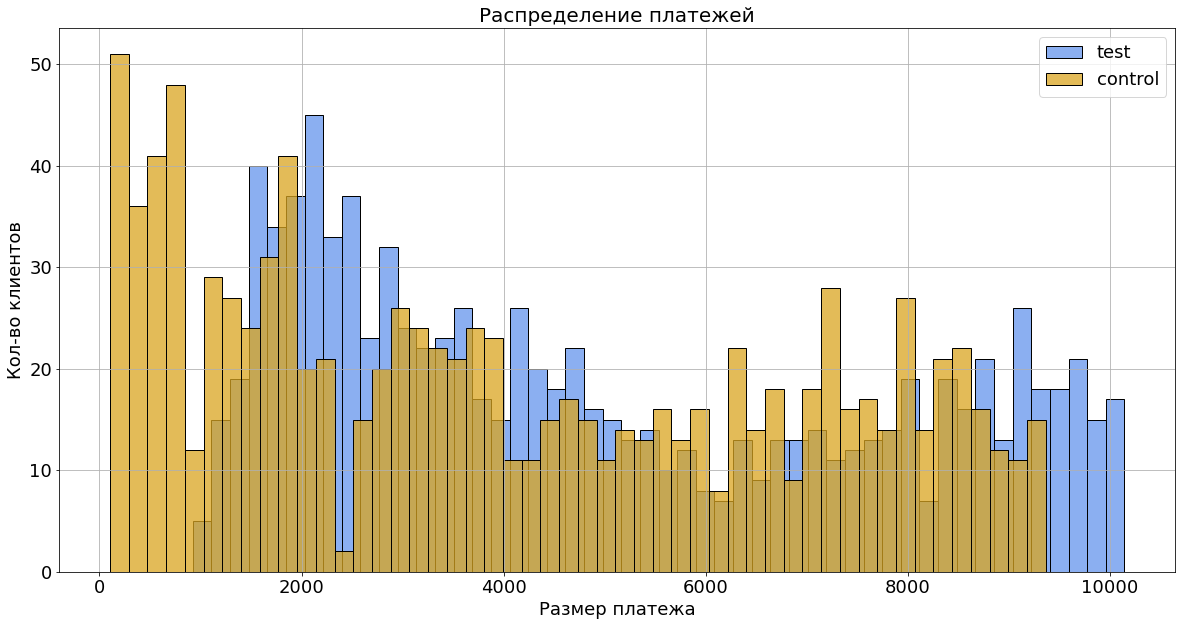

In [138]:
show_hist(data1.loc[data1['id_point']==1182.0]['sum_pay'],data2.loc[data2['id_point']==1182.0]['sum_pay'])

In [139]:
#По точке 1178.0 - нулевая гипотеза не подтверждается(акция не имеет очевидного положительного результата)
#По точке 1179.0 - нулевая гипотеза также не подтверждается(практически одинаковые результаты по группам)
#По точке 1182.0 - нулевая гипотеза подтверждается,виден очевидный результат акции(значения тестовой группы сдвинуты в право относительно контрольной)

In [140]:
#ЧАСТЬ 4

In [141]:
#Cегментирование пользователей с точки зрения длительности регистрации в программе лояльности

In [142]:
#Рассмотрите два вида корреляции между выплаченной суммой и длительностью регистрации 
#(корреляция Спирмена и корреляция Пирсона).

In [143]:
import scipy.stats as stats

In [144]:
#Строим функцию для определения корреляции Спирмена и корреляции Пирсона
def proxi_ranges(r1,r2,alpha = 0.05): 
    
    pearson_v,pearson_p=stats.pearsonr(r1,r2)
    spearman_v,spearman_p=stats.spearmanr(r1,r2)
    
    if pearson_p < alpha:
        if abs(pearson_v) < 0.3:
            status='слабая'
        elif abs(pearson_v) < 0.7:
            status='средняя'
        else: status='сильная'
        print (f'Корреляция Пирсона - {status}')
    else:print(f'Корреляция Пирсона = 0')
        
    if spearman_p < alpha:
        if abs(spearman_v) < 0.3:
            status='слабая'
        elif abs(spearman_v) < 0.7:
            status='средняя'
        else: status='сильная'
        print (f'Корреляция Спирмена - {status}')
    
    else:print(f'Корреляция Спирмена = 0')

In [145]:
proxi_ranges(ABtest['sum_pay'],ABtest['months_reg'])  

Корреляция Пирсона - средняя
Корреляция Спирмена - средняя


In [146]:
#Строим визуализацию связи между переменными

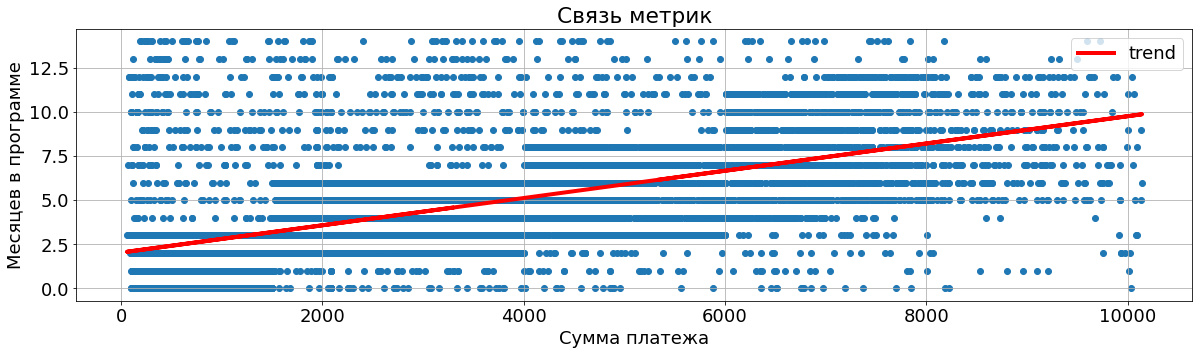

In [158]:
plt.rcParams['font.size'] = '18'
plt.figure(figsize=(20,5))
plt.title('Связь метрик')
plt.xlabel('Сумма платежа')
plt.ylabel('Месяцев в программе')
plt.grid()
plt.scatter(ABtest['sum_pay'],ABtest['months_reg'])
z = np.polyfit(ABtest['sum_pay'],ABtest['months_reg'], 1)
p = np.poly1d(z)
plt.plot(ABtest['sum_pay'],p(ABtest['sum_pay']),"r", label='trend',linewidth=4.0)
plt.legend(loc='upper right')
plt.savefig('Связь метрик.png')
plt.show()

In [159]:
#Наблюдаем среднюю корреляцию
#Чем дольше клиент в программе,тем выше сумма платежа

In [160]:
#Сгруппируем клиентов по месяцу регистрации и группе и подсчитаем сумму среднего платежа
df_group_mg=ABtest.groupby(['months_reg','id_group'])['sum_pay'].mean().reset_index()
df_group_mg

,months_reg,id_group,sum_pay
0,0,0,983.879310
1,0,1,976.519481
2,1,0,1126.747748
3,1,1,1033.080925
4,2,0,1726.727920
5,2,1,1833.432558
6,3,0,2326.963512
7,3,1,2423.092937
8,4,0,3752.900735
9,4,1,3772.688931


In [ ]:
#Визуализируем распределение клиентов по длительности регистрации в программе

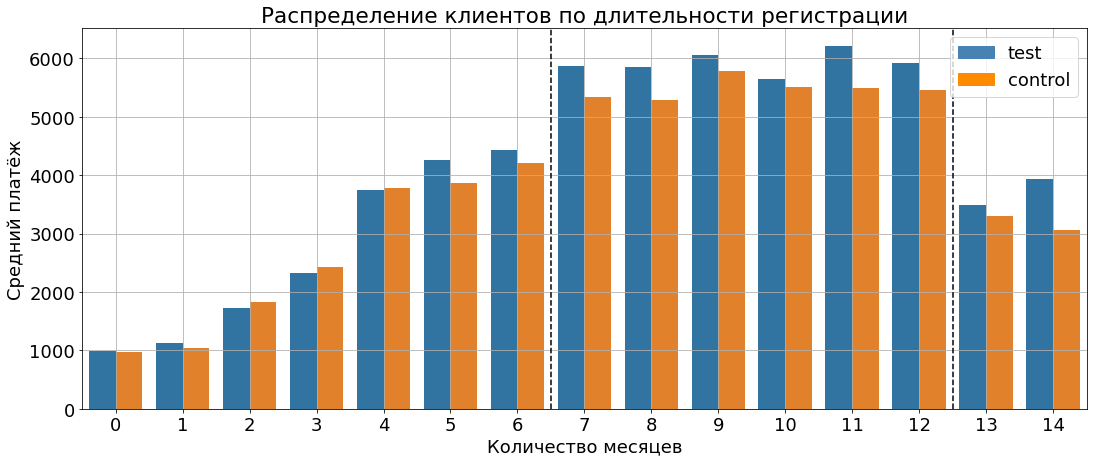

In [173]:
plt.rcParams['font.size'] = '18'
plt.figure(figsize=(18,7))
sns.barplot(x='months_reg',y='sum_pay',hue='id_group',data=df_group_mg)
plt.title('Распределение клиентов по длительности регистрации')
plt.xlabel('Количество месяцев')
plt.ylabel('Средний платёж')
plt.grid()
plt.axvline(x=6.5,color = 'k',linestyle = '--')
plt.axvline(x=12.5,color = 'k',linestyle = '--')
blue_patch = mpatches.Patch(color='steelblue', label='test')
orange_patch = mpatches.Patch(color='darkorange', label='control')
plt.legend(handles=[blue_patch,orange_patch],loc="upper right")
plt.savefig('Сегментация клиентов.png')

In [ ]:
#Первые 4 месяца сумма платежа значительно растет,с 4 по 7 месяц рост замедляется и практически стоит на месте до 12 месяца,после чего идёт снижение данного показателя
#Есть смысл обратить внимание на сегмент клиентов,зарегистрированных более 7 месяцев

In [656]:
#ОБЩИЕ ВЫВОДЫ

In [ ]:
#В целом увеличение бонусных баллов не приводит к значительным результатам т.к.
#Данные релевантны только по 3 точкам из 6,по двум точкам значимых результатов нет, динамика заметна только на одной точке
#По результатам данного теста нельзя считать тестовую акцию успешной,
#но т.к. на тест пошли не полные данные следует провести повторный сбор данных и тестирование
#Следует обратить внимание на сегмент клиентов, зарегистрированных более 7 месяцев-
#в данный период останавливается рост суммы среднего платежа,хотя в первые месяца программа лояльности работает успешно.

In [ ]:
Итоги работы представлены в презентации Coursework AB test